In [2]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
from IPython.core.display import Image, display
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline
from collections import Counter

from sklearn.metrics import classification_report

from keras import models, layers, optimizers
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import math
import pickle
import os
from PIL import ImageFile
import time

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
# from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [3]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    """Returns the path and the Label from the folder"""
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 14)
    return chest_files, chest_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../imgs/images/train')
test_files, test_targets = load_dataset('../imgs/images/test')

# load list of dog names
labels = [item[21:-1] for item in sorted(glob("../imgs/images/train/*/"))]
CLASSES = len(labels)

#proportions
train_prop = np.count_nonzero(train_targets, axis=0) / len(train_targets)
test_prop = np.count_nonzero(test_targets, axis=0) / len(test_targets)

print('Proportions: \n')
for index, label in enumerate(labels):
    print('{} train: {:.4f}'.format(label, train_prop[index]*100))
    print('{} test: {:.4f}'.format(label, test_prop[index]*100))
    print('*********************')

print('\nStatistics about the Dataset:\n')
print('There are %d total chest deseases.' % len(labels))
print('There are %s total chest images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training chest images.' % len(train_files))
print('There are %d test chest images.'% len(test_files))

Proportions: 

Atelectasis train: 15.9895
Atelectasis test: 10.6340
*********************
Cardiomegaly train: 4.0766
Cardiomegaly test: 7.8382
*********************
Consolidation train: 4.0077
Consolidation test: 5.1922
*********************
Edema train: 1.2533
Edema test: 2.3465
*********************
Effusion train: 12.5603
Effusion test: 11.6326
*********************
Emphysema train: 3.4155
Emphysema test: 3.2451
*********************
Fibrosis train: 4.0628
Fibrosis test: 3.7943
*********************
Hernia train: 0.4132
Hernia test: 1.1483
*********************
Infiltration train: 24.4732
Infiltration test: 29.8552
*********************
Mass train: 6.9274
Mass test: 3.4448
*********************
Nodule train: 10.8525
Nodule test: 4.5432
*********************
Pleural_Thickening train: 4.3796
Pleural_Thickening test: 4.9426
*********************
Pneumonia train: 0.9778
Pneumonia test: 1.1982
*********************
Pneumothorax train: 6.6107
Pneumothorax test: 10.1847
*******************

In [4]:
train_DENSNET = np.load('bottleneck_features_train.npy')
test_DENSNET = np.load('bottleneck_features_test.npy')

In [6]:
# Define the architecture
ChestRESN50_model = Sequential()
ChestRESN50_model.add(Flatten(input_shape=train_DENSNET.shape[1:]))
# ChestRESN50_model.add(GlobalAveragePooling2D(input_shape=(train_RESNET.shape[1:])))

ChestRESN50_model.add(layers.Dense(256))
ChestRESN50_model.add(layers.BatchNormalization())
ChestRESN50_model.add(layers.Activation('relu'))
ChestRESN50_model.add(layers.Dropout(0.5))

ChestRESN50_model.add(layers.Dense(CLASSES))
ChestRESN50_model.add(layers.BatchNormalization())
ChestRESN50_model.add(layers.Activation('softmax'))

ChestRESN50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               12845312  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                3598      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14)                56        
__________

In [7]:
# Compile the model
adam = optimizers.Adam(lr=0.0001)
ChestRESN50_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [9]:
train_DENSNET.shape, train_targets.shape

((7260, 7, 7, 1024), (7261, 14))

In [23]:
# Train the model with with the best weights.

# used to save the model that attains the best validation loss
checkpointer = ModelCheckpoint(filepath='weights.best.DENSNET121.hdf5', verbose=1, save_best_only=True)

History = ChestRESN50_model.fit(train_DENSNET, train_targets[:7260], 
          validation_split = 0.1,
          epochs=50, batch_size=40, callbacks=[checkpointer], verbose=1, shuffle=False)

Train on 6534 samples, validate on 726 samples
Epoch 1/50
6534/6534 [==============================] - ETA: 37s - loss: 0.1002 - acc: 0.95 - ETA: 38s - loss: 0.1071 - acc: 0.95 - ETA: 36s - loss: 0.1046 - acc: 0.95 - ETA: 37s - loss: 0.1030 - acc: 0.95 - ETA: 37s - loss: 0.1016 - acc: 0.95 - ETA: 37s - loss: 0.0986 - acc: 0.95 - ETA: 37s - loss: 0.1005 - acc: 0.95 - ETA: 37s - loss: 0.0997 - acc: 0.95 - ETA: 36s - loss: 0.0989 - acc: 0.95 - ETA: 37s - loss: 0.0992 - acc: 0.96 - ETA: 37s - loss: 0.0992 - acc: 0.95 - ETA: 36s - loss: 0.0998 - acc: 0.95 - ETA: 36s - loss: 0.1003 - acc: 0.95 - ETA: 36s - loss: 0.0999 - acc: 0.95 - ETA: 35s - loss: 0.1000 - acc: 0.95 - ETA: 35s - loss: 0.0999 - acc: 0.95 - ETA: 35s - loss: 0.0992 - acc: 0.95 - ETA: 35s - loss: 0.0987 - acc: 0.95 - ETA: 35s - loss: 0.0989 - acc: 0.95 - ETA: 34s - loss: 0.0996 - acc: 0.95 - ETA: 34s - loss: 0.0993 - acc: 0.95 - ETA: 34s - loss: 0.0991 - acc: 0.95 - ETA: 35s - loss: 0.0986 - acc: 0.95 - ETA: 35s - loss: 0.0981

6534/6534 [==============================] - ETA: 33s - loss: 0.1535 - acc: 0.93 - ETA: 36s - loss: 0.1531 - acc: 0.93 - ETA: 38s - loss: 0.1585 - acc: 0.93 - ETA: 38s - loss: 0.1524 - acc: 0.93 - ETA: 38s - loss: 0.1509 - acc: 0.94 - ETA: 38s - loss: 0.1474 - acc: 0.94 - ETA: 38s - loss: 0.1472 - acc: 0.94 - ETA: 38s - loss: 0.1468 - acc: 0.94 - ETA: 38s - loss: 0.1474 - acc: 0.94 - ETA: 38s - loss: 0.1470 - acc: 0.94 - ETA: 38s - loss: 0.1466 - acc: 0.94 - ETA: 38s - loss: 0.1462 - acc: 0.94 - ETA: 38s - loss: 0.1462 - acc: 0.94 - ETA: 38s - loss: 0.1451 - acc: 0.94 - ETA: 37s - loss: 0.1449 - acc: 0.94 - ETA: 37s - loss: 0.1437 - acc: 0.94 - ETA: 37s - loss: 0.1435 - acc: 0.94 - ETA: 37s - loss: 0.1432 - acc: 0.94 - ETA: 37s - loss: 0.1425 - acc: 0.94 - ETA: 36s - loss: 0.1423 - acc: 0.94 - ETA: 36s - loss: 0.1415 - acc: 0.94 - ETA: 36s - loss: 0.1407 - acc: 0.94 - ETA: 36s - loss: 0.1400 - acc: 0.94 - ETA: 36s - loss: 0.1389 - acc: 0.94 - ETA: 36s - loss: 0.1380 - acc: 0.94 - ETA: 

6534/6534 [==============================] - ETA: 36s - loss: 0.0953 - acc: 0.95 - ETA: 38s - loss: 0.1142 - acc: 0.95 - ETA: 39s - loss: 0.1118 - acc: 0.95 - ETA: 39s - loss: 0.1119 - acc: 0.95 - ETA: 39s - loss: 0.1115 - acc: 0.95 - ETA: 39s - loss: 0.1106 - acc: 0.95 - ETA: 39s - loss: 0.1107 - acc: 0.95 - ETA: 39s - loss: 0.1124 - acc: 0.95 - ETA: 39s - loss: 0.1121 - acc: 0.95 - ETA: 39s - loss: 0.1121 - acc: 0.95 - ETA: 39s - loss: 0.1123 - acc: 0.95 - ETA: 39s - loss: 0.1136 - acc: 0.95 - ETA: 38s - loss: 0.1138 - acc: 0.95 - ETA: 38s - loss: 0.1123 - acc: 0.95 - ETA: 38s - loss: 0.1123 - acc: 0.95 - ETA: 38s - loss: 0.1124 - acc: 0.95 - ETA: 38s - loss: 0.1119 - acc: 0.95 - ETA: 37s - loss: 0.1118 - acc: 0.95 - ETA: 37s - loss: 0.1114 - acc: 0.95 - ETA: 37s - loss: 0.1116 - acc: 0.95 - ETA: 37s - loss: 0.1114 - acc: 0.95 - ETA: 37s - loss: 0.1106 - acc: 0.95 - ETA: 36s - loss: 0.1103 - acc: 0.95 - ETA: 36s - loss: 0.1098 - acc: 0.95 - ETA: 36s - loss: 0.1095 - acc: 0.95 - ETA: 

6534/6534 [==============================] - ETA: 36s - loss: 0.1023 - acc: 0.95 - ETA: 38s - loss: 0.1071 - acc: 0.95 - ETA: 39s - loss: 0.1026 - acc: 0.95 - ETA: 39s - loss: 0.1005 - acc: 0.95 - ETA: 39s - loss: 0.1000 - acc: 0.95 - ETA: 39s - loss: 0.0971 - acc: 0.96 - ETA: 39s - loss: 0.0976 - acc: 0.96 - ETA: 39s - loss: 0.0978 - acc: 0.96 - ETA: 39s - loss: 0.0976 - acc: 0.96 - ETA: 39s - loss: 0.0983 - acc: 0.96 - ETA: 39s - loss: 0.0988 - acc: 0.96 - ETA: 39s - loss: 0.0991 - acc: 0.96 - ETA: 39s - loss: 0.0998 - acc: 0.95 - ETA: 39s - loss: 0.0994 - acc: 0.95 - ETA: 38s - loss: 0.0996 - acc: 0.95 - ETA: 38s - loss: 0.0998 - acc: 0.95 - ETA: 38s - loss: 0.0995 - acc: 0.95 - ETA: 38s - loss: 0.0991 - acc: 0.95 - ETA: 38s - loss: 0.0991 - acc: 0.95 - ETA: 37s - loss: 0.0997 - acc: 0.95 - ETA: 37s - loss: 0.0994 - acc: 0.95 - ETA: 37s - loss: 0.0989 - acc: 0.95 - ETA: 37s - loss: 0.0988 - acc: 0.95 - ETA: 37s - loss: 0.0982 - acc: 0.96 - ETA: 36s - loss: 0.0979 - acc: 0.96 - ETA: 

6534/6534 [==============================] - ETA: 45s - loss: 0.0898 - acc: 0.96 - ETA: 46s - loss: 0.0952 - acc: 0.95 - ETA: 45s - loss: 0.0913 - acc: 0.96 - ETA: 45s - loss: 0.0902 - acc: 0.96 - ETA: 45s - loss: 0.0895 - acc: 0.96 - ETA: 45s - loss: 0.0892 - acc: 0.96 - ETA: 45s - loss: 0.0901 - acc: 0.96 - ETA: 45s - loss: 0.0914 - acc: 0.96 - ETA: 44s - loss: 0.0904 - acc: 0.96 - ETA: 44s - loss: 0.0908 - acc: 0.96 - ETA: 43s - loss: 0.0916 - acc: 0.96 - ETA: 42s - loss: 0.0919 - acc: 0.96 - ETA: 42s - loss: 0.0924 - acc: 0.96 - ETA: 41s - loss: 0.0919 - acc: 0.96 - ETA: 41s - loss: 0.0922 - acc: 0.96 - ETA: 41s - loss: 0.0920 - acc: 0.96 - ETA: 40s - loss: 0.0913 - acc: 0.96 - ETA: 40s - loss: 0.0910 - acc: 0.96 - ETA: 40s - loss: 0.0907 - acc: 0.96 - ETA: 39s - loss: 0.0912 - acc: 0.96 - ETA: 39s - loss: 0.0909 - acc: 0.96 - ETA: 38s - loss: 0.0905 - acc: 0.96 - ETA: 38s - loss: 0.0905 - acc: 0.96 - ETA: 38s - loss: 0.0900 - acc: 0.96 - ETA: 38s - loss: 0.0901 - acc: 0.96 - ETA: 

6534/6534 [==============================] - ETA: 42s - loss: 0.0837 - acc: 0.96 - ETA: 44s - loss: 0.0892 - acc: 0.96 - ETA: 44s - loss: 0.0874 - acc: 0.96 - ETA: 44s - loss: 0.0854 - acc: 0.96 - ETA: 44s - loss: 0.0838 - acc: 0.96 - ETA: 44s - loss: 0.0819 - acc: 0.96 - ETA: 43s - loss: 0.0836 - acc: 0.96 - ETA: 43s - loss: 0.0846 - acc: 0.96 - ETA: 42s - loss: 0.0842 - acc: 0.96 - ETA: 42s - loss: 0.0845 - acc: 0.96 - ETA: 41s - loss: 0.0844 - acc: 0.96 - ETA: 41s - loss: 0.0847 - acc: 0.96 - ETA: 41s - loss: 0.0852 - acc: 0.96 - ETA: 40s - loss: 0.0848 - acc: 0.96 - ETA: 40s - loss: 0.0851 - acc: 0.96 - ETA: 40s - loss: 0.0852 - acc: 0.96 - ETA: 39s - loss: 0.0846 - acc: 0.96 - ETA: 39s - loss: 0.0843 - acc: 0.96 - ETA: 39s - loss: 0.0842 - acc: 0.96 - ETA: 38s - loss: 0.0849 - acc: 0.96 - ETA: 38s - loss: 0.0848 - acc: 0.96 - ETA: 38s - loss: 0.0846 - acc: 0.96 - ETA: 37s - loss: 0.0846 - acc: 0.96 - ETA: 37s - loss: 0.0843 - acc: 0.96 - ETA: 37s - loss: 0.0840 - acc: 0.96 - ETA: 

6534/6534 [==============================] - ETA: 40s - loss: 0.0837 - acc: 0.96 - ETA: 44s - loss: 0.0881 - acc: 0.96 - ETA: 44s - loss: 0.0844 - acc: 0.96 - ETA: 44s - loss: 0.0831 - acc: 0.96 - ETA: 44s - loss: 0.0829 - acc: 0.96 - ETA: 44s - loss: 0.0807 - acc: 0.97 - ETA: 44s - loss: 0.0818 - acc: 0.96 - ETA: 43s - loss: 0.0810 - acc: 0.97 - ETA: 42s - loss: 0.0808 - acc: 0.97 - ETA: 42s - loss: 0.0810 - acc: 0.97 - ETA: 41s - loss: 0.0812 - acc: 0.97 - ETA: 41s - loss: 0.0814 - acc: 0.97 - ETA: 40s - loss: 0.0816 - acc: 0.97 - ETA: 40s - loss: 0.0809 - acc: 0.97 - ETA: 40s - loss: 0.0812 - acc: 0.97 - ETA: 39s - loss: 0.0813 - acc: 0.97 - ETA: 39s - loss: 0.0812 - acc: 0.97 - ETA: 39s - loss: 0.0808 - acc: 0.97 - ETA: 38s - loss: 0.0807 - acc: 0.97 - ETA: 38s - loss: 0.0815 - acc: 0.97 - ETA: 38s - loss: 0.0809 - acc: 0.97 - ETA: 37s - loss: 0.0805 - acc: 0.97 - ETA: 37s - loss: 0.0805 - acc: 0.97 - ETA: 37s - loss: 0.0799 - acc: 0.97 - ETA: 37s - loss: 0.0796 - acc: 0.97 - ETA: 

6534/6534 [==============================] - ETA: 44s - loss: 0.0748 - acc: 0.97 - ETA: 45s - loss: 0.0802 - acc: 0.96 - ETA: 45s - loss: 0.0784 - acc: 0.97 - ETA: 45s - loss: 0.0770 - acc: 0.97 - ETA: 45s - loss: 0.0782 - acc: 0.97 - ETA: 44s - loss: 0.0768 - acc: 0.97 - ETA: 45s - loss: 0.0779 - acc: 0.97 - ETA: 44s - loss: 0.0774 - acc: 0.97 - ETA: 44s - loss: 0.0768 - acc: 0.97 - ETA: 44s - loss: 0.0772 - acc: 0.97 - ETA: 43s - loss: 0.0774 - acc: 0.97 - ETA: 43s - loss: 0.0777 - acc: 0.97 - ETA: 43s - loss: 0.0780 - acc: 0.97 - ETA: 43s - loss: 0.0776 - acc: 0.97 - ETA: 42s - loss: 0.0778 - acc: 0.97 - ETA: 42s - loss: 0.0779 - acc: 0.97 - ETA: 42s - loss: 0.0774 - acc: 0.97 - ETA: 41s - loss: 0.0772 - acc: 0.97 - ETA: 41s - loss: 0.0771 - acc: 0.97 - ETA: 41s - loss: 0.0777 - acc: 0.97 - ETA: 40s - loss: 0.0774 - acc: 0.97 - ETA: 40s - loss: 0.0769 - acc: 0.97 - ETA: 39s - loss: 0.0767 - acc: 0.97 - ETA: 39s - loss: 0.0763 - acc: 0.97 - ETA: 39s - loss: 0.0761 - acc: 0.97 - ETA: 

6534/6534 [==============================] - ETA: 45s - loss: 0.0770 - acc: 0.97 - ETA: 51s - loss: 0.0820 - acc: 0.97 - ETA: 50s - loss: 0.0794 - acc: 0.97 - ETA: 48s - loss: 0.0782 - acc: 0.97 - ETA: 49s - loss: 0.0772 - acc: 0.97 - ETA: 48s - loss: 0.0750 - acc: 0.97 - ETA: 47s - loss: 0.0752 - acc: 0.97 - ETA: 47s - loss: 0.0752 - acc: 0.97 - ETA: 46s - loss: 0.0746 - acc: 0.97 - ETA: 45s - loss: 0.0752 - acc: 0.97 - ETA: 45s - loss: 0.0753 - acc: 0.97 - ETA: 45s - loss: 0.0752 - acc: 0.97 - ETA: 44s - loss: 0.0760 - acc: 0.97 - ETA: 44s - loss: 0.0753 - acc: 0.97 - ETA: 43s - loss: 0.0755 - acc: 0.97 - ETA: 43s - loss: 0.0757 - acc: 0.97 - ETA: 42s - loss: 0.0754 - acc: 0.97 - ETA: 42s - loss: 0.0750 - acc: 0.97 - ETA: 42s - loss: 0.0747 - acc: 0.97 - ETA: 41s - loss: 0.0754 - acc: 0.97 - ETA: 41s - loss: 0.0750 - acc: 0.97 - ETA: 41s - loss: 0.0747 - acc: 0.97 - ETA: 40s - loss: 0.0744 - acc: 0.97 - ETA: 40s - loss: 0.0737 - acc: 0.97 - ETA: 40s - loss: 0.0735 - acc: 0.97 - ETA: 

6534/6534 [==============================] - ETA: 40s - loss: 0.0738 - acc: 0.97 - ETA: 41s - loss: 0.0796 - acc: 0.96 - ETA: 40s - loss: 0.0757 - acc: 0.97 - ETA: 40s - loss: 0.0743 - acc: 0.97 - ETA: 40s - loss: 0.0729 - acc: 0.97 - ETA: 40s - loss: 0.0710 - acc: 0.97 - ETA: 40s - loss: 0.0720 - acc: 0.97 - ETA: 40s - loss: 0.0712 - acc: 0.97 - ETA: 40s - loss: 0.0706 - acc: 0.97 - ETA: 40s - loss: 0.0712 - acc: 0.97 - ETA: 40s - loss: 0.0712 - acc: 0.97 - ETA: 40s - loss: 0.0715 - acc: 0.97 - ETA: 40s - loss: 0.0721 - acc: 0.97 - ETA: 40s - loss: 0.0720 - acc: 0.97 - ETA: 40s - loss: 0.0718 - acc: 0.97 - ETA: 40s - loss: 0.0718 - acc: 0.97 - ETA: 40s - loss: 0.0711 - acc: 0.97 - ETA: 40s - loss: 0.0710 - acc: 0.97 - ETA: 40s - loss: 0.0708 - acc: 0.97 - ETA: 39s - loss: 0.0714 - acc: 0.97 - ETA: 39s - loss: 0.0710 - acc: 0.97 - ETA: 39s - loss: 0.0709 - acc: 0.97 - ETA: 39s - loss: 0.0707 - acc: 0.97 - ETA: 38s - loss: 0.0706 - acc: 0.97 - ETA: 38s - loss: 0.0707 - acc: 0.97 - ETA: 

6534/6534 [==============================] - ETA: 40s - loss: 0.0725 - acc: 0.97 - ETA: 41s - loss: 0.0749 - acc: 0.97 - ETA: 41s - loss: 0.0720 - acc: 0.97 - ETA: 40s - loss: 0.0710 - acc: 0.97 - ETA: 40s - loss: 0.0712 - acc: 0.97 - ETA: 40s - loss: 0.0698 - acc: 0.97 - ETA: 40s - loss: 0.0711 - acc: 0.97 - ETA: 40s - loss: 0.0700 - acc: 0.97 - ETA: 40s - loss: 0.0692 - acc: 0.97 - ETA: 39s - loss: 0.0695 - acc: 0.97 - ETA: 39s - loss: 0.0695 - acc: 0.97 - ETA: 39s - loss: 0.0697 - acc: 0.97 - ETA: 39s - loss: 0.0699 - acc: 0.97 - ETA: 38s - loss: 0.0695 - acc: 0.97 - ETA: 38s - loss: 0.0695 - acc: 0.97 - ETA: 38s - loss: 0.0695 - acc: 0.97 - ETA: 38s - loss: 0.0688 - acc: 0.97 - ETA: 38s - loss: 0.0689 - acc: 0.97 - ETA: 38s - loss: 0.0685 - acc: 0.97 - ETA: 38s - loss: 0.0693 - acc: 0.97 - ETA: 38s - loss: 0.0688 - acc: 0.97 - ETA: 37s - loss: 0.0683 - acc: 0.97 - ETA: 37s - loss: 0.0680 - acc: 0.97 - ETA: 37s - loss: 0.0678 - acc: 0.97 - ETA: 37s - loss: 0.0678 - acc: 0.97 - ETA: 

6534/6534 [==============================] - ETA: 41s - loss: 0.0582 - acc: 0.98 - ETA: 41s - loss: 0.0669 - acc: 0.98 - ETA: 42s - loss: 0.0662 - acc: 0.98 - ETA: 42s - loss: 0.0658 - acc: 0.98 - ETA: 41s - loss: 0.0657 - acc: 0.98 - ETA: 41s - loss: 0.0644 - acc: 0.98 - ETA: 41s - loss: 0.0657 - acc: 0.98 - ETA: 41s - loss: 0.0657 - acc: 0.98 - ETA: 40s - loss: 0.0658 - acc: 0.98 - ETA: 40s - loss: 0.0664 - acc: 0.98 - ETA: 40s - loss: 0.0666 - acc: 0.98 - ETA: 40s - loss: 0.0675 - acc: 0.98 - ETA: 39s - loss: 0.0676 - acc: 0.98 - ETA: 39s - loss: 0.0671 - acc: 0.98 - ETA: 39s - loss: 0.0670 - acc: 0.98 - ETA: 39s - loss: 0.0669 - acc: 0.98 - ETA: 38s - loss: 0.0663 - acc: 0.98 - ETA: 38s - loss: 0.0662 - acc: 0.98 - ETA: 38s - loss: 0.0659 - acc: 0.98 - ETA: 37s - loss: 0.0666 - acc: 0.98 - ETA: 37s - loss: 0.0662 - acc: 0.98 - ETA: 37s - loss: 0.0660 - acc: 0.98 - ETA: 37s - loss: 0.0658 - acc: 0.98 - ETA: 37s - loss: 0.0655 - acc: 0.98 - ETA: 36s - loss: 0.0654 - acc: 0.98 - ETA: 

6534/6534 [==============================] - ETA: 44s - loss: 0.0625 - acc: 0.98 - ETA: 45s - loss: 0.0686 - acc: 0.97 - ETA: 46s - loss: 0.0678 - acc: 0.97 - ETA: 45s - loss: 0.0656 - acc: 0.97 - ETA: 44s - loss: 0.0640 - acc: 0.98 - ETA: 43s - loss: 0.0625 - acc: 0.98 - ETA: 42s - loss: 0.0638 - acc: 0.98 - ETA: 42s - loss: 0.0628 - acc: 0.98 - ETA: 41s - loss: 0.0626 - acc: 0.98 - ETA: 41s - loss: 0.0629 - acc: 0.98 - ETA: 41s - loss: 0.0632 - acc: 0.98 - ETA: 40s - loss: 0.0637 - acc: 0.98 - ETA: 40s - loss: 0.0643 - acc: 0.98 - ETA: 40s - loss: 0.0638 - acc: 0.98 - ETA: 39s - loss: 0.0641 - acc: 0.98 - ETA: 39s - loss: 0.0643 - acc: 0.98 - ETA: 39s - loss: 0.0636 - acc: 0.98 - ETA: 38s - loss: 0.0635 - acc: 0.98 - ETA: 38s - loss: 0.0635 - acc: 0.98 - ETA: 38s - loss: 0.0640 - acc: 0.98 - ETA: 37s - loss: 0.0636 - acc: 0.98 - ETA: 37s - loss: 0.0634 - acc: 0.98 - ETA: 37s - loss: 0.0632 - acc: 0.98 - ETA: 36s - loss: 0.0629 - acc: 0.98 - ETA: 36s - loss: 0.0627 - acc: 0.98 - ETA: 

6534/6534 [==============================] - ETA: 46s - loss: 0.0604 - acc: 0.99 - ETA: 48s - loss: 0.0658 - acc: 0.98 - ETA: 49s - loss: 0.0632 - acc: 0.98 - ETA: 48s - loss: 0.0633 - acc: 0.98 - ETA: 49s - loss: 0.0620 - acc: 0.98 - ETA: 48s - loss: 0.0607 - acc: 0.98 - ETA: 49s - loss: 0.0619 - acc: 0.98 - ETA: 48s - loss: 0.0614 - acc: 0.98 - ETA: 47s - loss: 0.0609 - acc: 0.98 - ETA: 46s - loss: 0.0620 - acc: 0.98 - ETA: 45s - loss: 0.0621 - acc: 0.98 - ETA: 44s - loss: 0.0619 - acc: 0.98 - ETA: 44s - loss: 0.0622 - acc: 0.98 - ETA: 43s - loss: 0.0620 - acc: 0.98 - ETA: 43s - loss: 0.0620 - acc: 0.98 - ETA: 42s - loss: 0.0621 - acc: 0.98 - ETA: 41s - loss: 0.0614 - acc: 0.98 - ETA: 41s - loss: 0.0612 - acc: 0.98 - ETA: 40s - loss: 0.0611 - acc: 0.98 - ETA: 40s - loss: 0.0616 - acc: 0.98 - ETA: 40s - loss: 0.0612 - acc: 0.98 - ETA: 39s - loss: 0.0607 - acc: 0.98 - ETA: 39s - loss: 0.0607 - acc: 0.98 - ETA: 38s - loss: 0.0604 - acc: 0.98 - ETA: 38s - loss: 0.0604 - acc: 0.98 - ETA: 

6534/6534 [==============================] - ETA: 42s - loss: 0.0603 - acc: 0.98 - ETA: 44s - loss: 0.0663 - acc: 0.98 - ETA: 45s - loss: 0.0641 - acc: 0.98 - ETA: 45s - loss: 0.0624 - acc: 0.98 - ETA: 45s - loss: 0.0611 - acc: 0.98 - ETA: 44s - loss: 0.0598 - acc: 0.98 - ETA: 44s - loss: 0.0606 - acc: 0.98 - ETA: 44s - loss: 0.0604 - acc: 0.98 - ETA: 43s - loss: 0.0600 - acc: 0.98 - ETA: 43s - loss: 0.0603 - acc: 0.98 - ETA: 43s - loss: 0.0599 - acc: 0.98 - ETA: 43s - loss: 0.0599 - acc: 0.98 - ETA: 42s - loss: 0.0603 - acc: 0.98 - ETA: 42s - loss: 0.0601 - acc: 0.98 - ETA: 42s - loss: 0.0601 - acc: 0.98 - ETA: 41s - loss: 0.0603 - acc: 0.98 - ETA: 41s - loss: 0.0596 - acc: 0.98 - ETA: 41s - loss: 0.0594 - acc: 0.98 - ETA: 40s - loss: 0.0593 - acc: 0.98 - ETA: 40s - loss: 0.0599 - acc: 0.98 - ETA: 39s - loss: 0.0596 - acc: 0.98 - ETA: 39s - loss: 0.0592 - acc: 0.98 - ETA: 39s - loss: 0.0591 - acc: 0.98 - ETA: 38s - loss: 0.0589 - acc: 0.98 - ETA: 38s - loss: 0.0587 - acc: 0.98 - ETA: 

6534/6534 [==============================] - ETA: 44s - loss: 0.0595 - acc: 0.98 - ETA: 45s - loss: 0.0649 - acc: 0.98 - ETA: 44s - loss: 0.0631 - acc: 0.98 - ETA: 44s - loss: 0.0605 - acc: 0.98 - ETA: 44s - loss: 0.0593 - acc: 0.98 - ETA: 44s - loss: 0.0575 - acc: 0.98 - ETA: 44s - loss: 0.0579 - acc: 0.98 - ETA: 43s - loss: 0.0570 - acc: 0.98 - ETA: 43s - loss: 0.0566 - acc: 0.98 - ETA: 43s - loss: 0.0570 - acc: 0.98 - ETA: 43s - loss: 0.0568 - acc: 0.98 - ETA: 43s - loss: 0.0574 - acc: 0.98 - ETA: 42s - loss: 0.0577 - acc: 0.98 - ETA: 42s - loss: 0.0579 - acc: 0.98 - ETA: 42s - loss: 0.0581 - acc: 0.98 - ETA: 42s - loss: 0.0580 - acc: 0.98 - ETA: 41s - loss: 0.0576 - acc: 0.98 - ETA: 41s - loss: 0.0574 - acc: 0.98 - ETA: 41s - loss: 0.0572 - acc: 0.98 - ETA: 41s - loss: 0.0578 - acc: 0.98 - ETA: 40s - loss: 0.0576 - acc: 0.98 - ETA: 40s - loss: 0.0571 - acc: 0.98 - ETA: 40s - loss: 0.0570 - acc: 0.98 - ETA: 39s - loss: 0.0567 - acc: 0.98 - ETA: 39s - loss: 0.0567 - acc: 0.98 - ETA: 

6534/6534 [==============================] - ETA: 45s - loss: 0.0589 - acc: 0.98 - ETA: 44s - loss: 0.0638 - acc: 0.97 - ETA: 45s - loss: 0.0628 - acc: 0.98 - ETA: 45s - loss: 0.0614 - acc: 0.98 - ETA: 44s - loss: 0.0604 - acc: 0.98 - ETA: 44s - loss: 0.0581 - acc: 0.98 - ETA: 44s - loss: 0.0583 - acc: 0.98 - ETA: 44s - loss: 0.0572 - acc: 0.98 - ETA: 44s - loss: 0.0570 - acc: 0.98 - ETA: 43s - loss: 0.0571 - acc: 0.98 - ETA: 43s - loss: 0.0569 - acc: 0.98 - ETA: 43s - loss: 0.0571 - acc: 0.98 - ETA: 42s - loss: 0.0575 - acc: 0.98 - ETA: 42s - loss: 0.0571 - acc: 0.98 - ETA: 42s - loss: 0.0572 - acc: 0.98 - ETA: 42s - loss: 0.0572 - acc: 0.98 - ETA: 41s - loss: 0.0568 - acc: 0.98 - ETA: 41s - loss: 0.0566 - acc: 0.98 - ETA: 41s - loss: 0.0564 - acc: 0.98 - ETA: 41s - loss: 0.0569 - acc: 0.98 - ETA: 40s - loss: 0.0567 - acc: 0.98 - ETA: 40s - loss: 0.0562 - acc: 0.98 - ETA: 40s - loss: 0.0562 - acc: 0.98 - ETA: 40s - loss: 0.0558 - acc: 0.98 - ETA: 39s - loss: 0.0558 - acc: 0.98 - ETA: 

6534/6534 [==============================] - ETA: 39s - loss: 0.0525 - acc: 0.99 - ETA: 40s - loss: 0.0577 - acc: 0.98 - ETA: 40s - loss: 0.0551 - acc: 0.98 - ETA: 40s - loss: 0.0541 - acc: 0.98 - ETA: 40s - loss: 0.0533 - acc: 0.99 - ETA: 40s - loss: 0.0514 - acc: 0.99 - ETA: 41s - loss: 0.0525 - acc: 0.99 - ETA: 41s - loss: 0.0518 - acc: 0.99 - ETA: 41s - loss: 0.0517 - acc: 0.99 - ETA: 41s - loss: 0.0522 - acc: 0.99 - ETA: 41s - loss: 0.0520 - acc: 0.99 - ETA: 41s - loss: 0.0524 - acc: 0.99 - ETA: 41s - loss: 0.0527 - acc: 0.99 - ETA: 41s - loss: 0.0525 - acc: 0.99 - ETA: 41s - loss: 0.0531 - acc: 0.99 - ETA: 41s - loss: 0.0534 - acc: 0.99 - ETA: 41s - loss: 0.0529 - acc: 0.99 - ETA: 40s - loss: 0.0528 - acc: 0.99 - ETA: 40s - loss: 0.0529 - acc: 0.99 - ETA: 40s - loss: 0.0535 - acc: 0.99 - ETA: 40s - loss: 0.0530 - acc: 0.99 - ETA: 39s - loss: 0.0527 - acc: 0.99 - ETA: 39s - loss: 0.0528 - acc: 0.99 - ETA: 39s - loss: 0.0523 - acc: 0.99 - ETA: 39s - loss: 0.0522 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 39s - loss: 0.0521 - acc: 0.99 - ETA: 40s - loss: 0.0559 - acc: 0.98 - ETA: 40s - loss: 0.0541 - acc: 0.98 - ETA: 40s - loss: 0.0526 - acc: 0.98 - ETA: 40s - loss: 0.0519 - acc: 0.98 - ETA: 40s - loss: 0.0501 - acc: 0.99 - ETA: 40s - loss: 0.0514 - acc: 0.98 - ETA: 40s - loss: 0.0510 - acc: 0.98 - ETA: 39s - loss: 0.0512 - acc: 0.98 - ETA: 39s - loss: 0.0521 - acc: 0.98 - ETA: 39s - loss: 0.0523 - acc: 0.98 - ETA: 39s - loss: 0.0524 - acc: 0.98 - ETA: 38s - loss: 0.0527 - acc: 0.98 - ETA: 38s - loss: 0.0526 - acc: 0.98 - ETA: 38s - loss: 0.0532 - acc: 0.98 - ETA: 38s - loss: 0.0533 - acc: 0.98 - ETA: 38s - loss: 0.0530 - acc: 0.98 - ETA: 38s - loss: 0.0530 - acc: 0.98 - ETA: 38s - loss: 0.0530 - acc: 0.98 - ETA: 38s - loss: 0.0534 - acc: 0.98 - ETA: 38s - loss: 0.0530 - acc: 0.98 - ETA: 38s - loss: 0.0528 - acc: 0.98 - ETA: 38s - loss: 0.0526 - acc: 0.98 - ETA: 38s - loss: 0.0523 - acc: 0.98 - ETA: 38s - loss: 0.0522 - acc: 0.98 - ETA: 

6534/6534 [==============================] - ETA: 39s - loss: 0.0526 - acc: 0.99 - ETA: 40s - loss: 0.0563 - acc: 0.98 - ETA: 40s - loss: 0.0540 - acc: 0.98 - ETA: 40s - loss: 0.0528 - acc: 0.98 - ETA: 40s - loss: 0.0522 - acc: 0.98 - ETA: 40s - loss: 0.0506 - acc: 0.99 - ETA: 40s - loss: 0.0508 - acc: 0.99 - ETA: 40s - loss: 0.0499 - acc: 0.99 - ETA: 39s - loss: 0.0498 - acc: 0.99 - ETA: 39s - loss: 0.0500 - acc: 0.99 - ETA: 39s - loss: 0.0500 - acc: 0.99 - ETA: 39s - loss: 0.0508 - acc: 0.99 - ETA: 38s - loss: 0.0515 - acc: 0.99 - ETA: 38s - loss: 0.0512 - acc: 0.99 - ETA: 38s - loss: 0.0514 - acc: 0.99 - ETA: 38s - loss: 0.0516 - acc: 0.99 - ETA: 37s - loss: 0.0512 - acc: 0.99 - ETA: 37s - loss: 0.0511 - acc: 0.99 - ETA: 37s - loss: 0.0510 - acc: 0.99 - ETA: 37s - loss: 0.0515 - acc: 0.99 - ETA: 37s - loss: 0.0511 - acc: 0.99 - ETA: 36s - loss: 0.0507 - acc: 0.99 - ETA: 36s - loss: 0.0507 - acc: 0.99 - ETA: 36s - loss: 0.0502 - acc: 0.99 - ETA: 36s - loss: 0.0501 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 41s - loss: 0.0507 - acc: 0.98 - ETA: 41s - loss: 0.0561 - acc: 0.98 - ETA: 41s - loss: 0.0541 - acc: 0.98 - ETA: 41s - loss: 0.0529 - acc: 0.98 - ETA: 41s - loss: 0.0524 - acc: 0.99 - ETA: 40s - loss: 0.0509 - acc: 0.99 - ETA: 40s - loss: 0.0514 - acc: 0.99 - ETA: 40s - loss: 0.0509 - acc: 0.99 - ETA: 40s - loss: 0.0503 - acc: 0.99 - ETA: 39s - loss: 0.0501 - acc: 0.99 - ETA: 39s - loss: 0.0500 - acc: 0.99 - ETA: 39s - loss: 0.0503 - acc: 0.99 - ETA: 39s - loss: 0.0506 - acc: 0.99 - ETA: 38s - loss: 0.0507 - acc: 0.99 - ETA: 38s - loss: 0.0510 - acc: 0.99 - ETA: 38s - loss: 0.0511 - acc: 0.99 - ETA: 38s - loss: 0.0507 - acc: 0.99 - ETA: 38s - loss: 0.0506 - acc: 0.99 - ETA: 37s - loss: 0.0505 - acc: 0.99 - ETA: 37s - loss: 0.0510 - acc: 0.99 - ETA: 37s - loss: 0.0507 - acc: 0.99 - ETA: 36s - loss: 0.0504 - acc: 0.99 - ETA: 36s - loss: 0.0504 - acc: 0.99 - ETA: 36s - loss: 0.0499 - acc: 0.99 - ETA: 36s - loss: 0.0496 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 46s - loss: 0.0502 - acc: 0.99 - ETA: 47s - loss: 0.0529 - acc: 0.98 - ETA: 47s - loss: 0.0526 - acc: 0.98 - ETA: 46s - loss: 0.0522 - acc: 0.99 - ETA: 45s - loss: 0.0521 - acc: 0.98 - ETA: 45s - loss: 0.0501 - acc: 0.99 - ETA: 45s - loss: 0.0509 - acc: 0.99 - ETA: 45s - loss: 0.0500 - acc: 0.99 - ETA: 44s - loss: 0.0501 - acc: 0.99 - ETA: 45s - loss: 0.0499 - acc: 0.99 - ETA: 44s - loss: 0.0494 - acc: 0.99 - ETA: 44s - loss: 0.0493 - acc: 0.99 - ETA: 43s - loss: 0.0499 - acc: 0.99 - ETA: 43s - loss: 0.0498 - acc: 0.99 - ETA: 42s - loss: 0.0502 - acc: 0.99 - ETA: 42s - loss: 0.0506 - acc: 0.99 - ETA: 41s - loss: 0.0499 - acc: 0.99 - ETA: 41s - loss: 0.0496 - acc: 0.99 - ETA: 40s - loss: 0.0497 - acc: 0.99 - ETA: 40s - loss: 0.0501 - acc: 0.99 - ETA: 39s - loss: 0.0497 - acc: 0.99 - ETA: 39s - loss: 0.0493 - acc: 0.99 - ETA: 39s - loss: 0.0492 - acc: 0.99 - ETA: 38s - loss: 0.0488 - acc: 0.99 - ETA: 38s - loss: 0.0485 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 44s - loss: 0.0456 - acc: 0.99 - ETA: 45s - loss: 0.0499 - acc: 0.99 - ETA: 46s - loss: 0.0485 - acc: 0.99 - ETA: 45s - loss: 0.0478 - acc: 0.99 - ETA: 45s - loss: 0.0478 - acc: 0.99 - ETA: 45s - loss: 0.0463 - acc: 0.99 - ETA: 44s - loss: 0.0475 - acc: 0.99 - ETA: 44s - loss: 0.0473 - acc: 0.99 - ETA: 44s - loss: 0.0475 - acc: 0.99 - ETA: 43s - loss: 0.0481 - acc: 0.99 - ETA: 43s - loss: 0.0478 - acc: 0.99 - ETA: 43s - loss: 0.0482 - acc: 0.99 - ETA: 43s - loss: 0.0485 - acc: 0.99 - ETA: 42s - loss: 0.0480 - acc: 0.99 - ETA: 42s - loss: 0.0482 - acc: 0.99 - ETA: 42s - loss: 0.0482 - acc: 0.99 - ETA: 42s - loss: 0.0477 - acc: 0.99 - ETA: 41s - loss: 0.0474 - acc: 0.99 - ETA: 41s - loss: 0.0472 - acc: 0.99 - ETA: 41s - loss: 0.0476 - acc: 0.99 - ETA: 40s - loss: 0.0473 - acc: 0.99 - ETA: 40s - loss: 0.0470 - acc: 0.99 - ETA: 40s - loss: 0.0470 - acc: 0.99 - ETA: 40s - loss: 0.0467 - acc: 0.99 - ETA: 40s - loss: 0.0466 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 43s - loss: 0.0474 - acc: 0.99 - ETA: 44s - loss: 0.0499 - acc: 0.98 - ETA: 45s - loss: 0.0487 - acc: 0.99 - ETA: 44s - loss: 0.0472 - acc: 0.99 - ETA: 44s - loss: 0.0463 - acc: 0.99 - ETA: 44s - loss: 0.0449 - acc: 0.99 - ETA: 44s - loss: 0.0460 - acc: 0.99 - ETA: 44s - loss: 0.0453 - acc: 0.99 - ETA: 44s - loss: 0.0454 - acc: 0.99 - ETA: 43s - loss: 0.0456 - acc: 0.99 - ETA: 43s - loss: 0.0457 - acc: 0.99 - ETA: 43s - loss: 0.0459 - acc: 0.99 - ETA: 42s - loss: 0.0461 - acc: 0.99 - ETA: 42s - loss: 0.0461 - acc: 0.99 - ETA: 42s - loss: 0.0464 - acc: 0.99 - ETA: 41s - loss: 0.0464 - acc: 0.99 - ETA: 41s - loss: 0.0457 - acc: 0.99 - ETA: 41s - loss: 0.0458 - acc: 0.99 - ETA: 41s - loss: 0.0456 - acc: 0.99 - ETA: 40s - loss: 0.0461 - acc: 0.99 - ETA: 40s - loss: 0.0457 - acc: 0.99 - ETA: 40s - loss: 0.0453 - acc: 0.99 - ETA: 40s - loss: 0.0453 - acc: 0.99 - ETA: 39s - loss: 0.0449 - acc: 0.99 - ETA: 39s - loss: 0.0449 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 40s - loss: 0.0446 - acc: 0.99 - ETA: 41s - loss: 0.0498 - acc: 0.99 - ETA: 42s - loss: 0.0475 - acc: 0.99 - ETA: 42s - loss: 0.0460 - acc: 0.99 - ETA: 44s - loss: 0.0450 - acc: 0.99 - ETA: 44s - loss: 0.0433 - acc: 0.99 - ETA: 43s - loss: 0.0444 - acc: 0.99 - ETA: 43s - loss: 0.0438 - acc: 0.99 - ETA: 43s - loss: 0.0437 - acc: 0.99 - ETA: 43s - loss: 0.0442 - acc: 0.99 - ETA: 43s - loss: 0.0439 - acc: 0.99 - ETA: 43s - loss: 0.0438 - acc: 0.99 - ETA: 42s - loss: 0.0443 - acc: 0.99 - ETA: 42s - loss: 0.0441 - acc: 0.99 - ETA: 42s - loss: 0.0445 - acc: 0.99 - ETA: 41s - loss: 0.0448 - acc: 0.99 - ETA: 41s - loss: 0.0443 - acc: 0.99 - ETA: 41s - loss: 0.0443 - acc: 0.99 - ETA: 40s - loss: 0.0442 - acc: 0.99 - ETA: 40s - loss: 0.0448 - acc: 0.99 - ETA: 40s - loss: 0.0445 - acc: 0.99 - ETA: 40s - loss: 0.0443 - acc: 0.99 - ETA: 39s - loss: 0.0442 - acc: 0.99 - ETA: 39s - loss: 0.0439 - acc: 0.99 - ETA: 39s - loss: 0.0438 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 40s - loss: 0.0406 - acc: 0.99 - ETA: 41s - loss: 0.0472 - acc: 0.99 - ETA: 41s - loss: 0.0469 - acc: 0.99 - ETA: 41s - loss: 0.0457 - acc: 0.99 - ETA: 40s - loss: 0.0439 - acc: 0.99 - ETA: 40s - loss: 0.0428 - acc: 0.99 - ETA: 40s - loss: 0.0434 - acc: 0.99 - ETA: 40s - loss: 0.0431 - acc: 0.99 - ETA: 39s - loss: 0.0434 - acc: 0.99 - ETA: 39s - loss: 0.0444 - acc: 0.99 - ETA: 39s - loss: 0.0443 - acc: 0.99 - ETA: 39s - loss: 0.0441 - acc: 0.99 - ETA: 39s - loss: 0.0444 - acc: 0.99 - ETA: 39s - loss: 0.0441 - acc: 0.99 - ETA: 39s - loss: 0.0445 - acc: 0.99 - ETA: 39s - loss: 0.0450 - acc: 0.99 - ETA: 39s - loss: 0.0445 - acc: 0.99 - ETA: 39s - loss: 0.0443 - acc: 0.99 - ETA: 39s - loss: 0.0440 - acc: 0.99 - ETA: 39s - loss: 0.0443 - acc: 0.99 - ETA: 39s - loss: 0.0438 - acc: 0.99 - ETA: 38s - loss: 0.0435 - acc: 0.99 - ETA: 38s - loss: 0.0433 - acc: 0.99 - ETA: 38s - loss: 0.0429 - acc: 0.99 - ETA: 38s - loss: 0.0428 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 40s - loss: 0.0404 - acc: 1.00 - ETA: 40s - loss: 0.0429 - acc: 0.99 - ETA: 39s - loss: 0.0423 - acc: 0.99 - ETA: 40s - loss: 0.0419 - acc: 0.99 - ETA: 41s - loss: 0.0417 - acc: 0.99 - ETA: 40s - loss: 0.0409 - acc: 0.99 - ETA: 39s - loss: 0.0416 - acc: 0.99 - ETA: 41s - loss: 0.0410 - acc: 0.99 - ETA: 42s - loss: 0.0410 - acc: 0.99 - ETA: 42s - loss: 0.0417 - acc: 0.99 - ETA: 41s - loss: 0.0418 - acc: 0.99 - ETA: 42s - loss: 0.0421 - acc: 0.99 - ETA: 41s - loss: 0.0425 - acc: 0.99 - ETA: 41s - loss: 0.0423 - acc: 0.99 - ETA: 41s - loss: 0.0426 - acc: 0.99 - ETA: 41s - loss: 0.0428 - acc: 0.99 - ETA: 41s - loss: 0.0424 - acc: 0.99 - ETA: 41s - loss: 0.0424 - acc: 0.99 - ETA: 40s - loss: 0.0424 - acc: 0.99 - ETA: 40s - loss: 0.0427 - acc: 0.99 - ETA: 40s - loss: 0.0424 - acc: 0.99 - ETA: 40s - loss: 0.0419 - acc: 0.99 - ETA: 40s - loss: 0.0418 - acc: 0.99 - ETA: 41s - loss: 0.0415 - acc: 0.99 - ETA: 42s - loss: 0.0414 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 46s - loss: 0.0393 - acc: 0.99 - ETA: 46s - loss: 0.0445 - acc: 0.99 - ETA: 47s - loss: 0.0436 - acc: 0.99 - ETA: 46s - loss: 0.0421 - acc: 0.99 - ETA: 46s - loss: 0.0419 - acc: 0.99 - ETA: 46s - loss: 0.0408 - acc: 0.99 - ETA: 46s - loss: 0.0414 - acc: 0.99 - ETA: 46s - loss: 0.0409 - acc: 0.99 - ETA: 46s - loss: 0.0406 - acc: 0.99 - ETA: 46s - loss: 0.0409 - acc: 0.99 - ETA: 45s - loss: 0.0407 - acc: 0.99 - ETA: 45s - loss: 0.0408 - acc: 0.99 - ETA: 44s - loss: 0.0410 - acc: 0.99 - ETA: 44s - loss: 0.0407 - acc: 0.99 - ETA: 44s - loss: 0.0412 - acc: 0.99 - ETA: 43s - loss: 0.0413 - acc: 0.99 - ETA: 43s - loss: 0.0408 - acc: 0.99 - ETA: 42s - loss: 0.0405 - acc: 0.99 - ETA: 42s - loss: 0.0405 - acc: 0.99 - ETA: 41s - loss: 0.0410 - acc: 0.99 - ETA: 41s - loss: 0.0407 - acc: 0.99 - ETA: 40s - loss: 0.0407 - acc: 0.99 - ETA: 40s - loss: 0.0408 - acc: 0.99 - ETA: 39s - loss: 0.0405 - acc: 0.99 - ETA: 39s - loss: 0.0406 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 43s - loss: 0.0362 - acc: 0.99 - ETA: 46s - loss: 0.0423 - acc: 0.99 - ETA: 48s - loss: 0.0424 - acc: 0.99 - ETA: 47s - loss: 0.0412 - acc: 0.99 - ETA: 48s - loss: 0.0407 - acc: 0.99 - ETA: 51s - loss: 0.0396 - acc: 0.99 - ETA: 51s - loss: 0.0400 - acc: 0.99 - ETA: 50s - loss: 0.0395 - acc: 0.99 - ETA: 49s - loss: 0.0395 - acc: 0.99 - ETA: 48s - loss: 0.0393 - acc: 0.99 - ETA: 47s - loss: 0.0392 - acc: 0.99 - ETA: 46s - loss: 0.0391 - acc: 0.99 - ETA: 45s - loss: 0.0394 - acc: 0.99 - ETA: 44s - loss: 0.0393 - acc: 0.99 - ETA: 44s - loss: 0.0395 - acc: 0.99 - ETA: 44s - loss: 0.0399 - acc: 0.99 - ETA: 44s - loss: 0.0395 - acc: 0.99 - ETA: 44s - loss: 0.0394 - acc: 0.99 - ETA: 44s - loss: 0.0392 - acc: 0.99 - ETA: 43s - loss: 0.0398 - acc: 0.99 - ETA: 42s - loss: 0.0395 - acc: 0.99 - ETA: 42s - loss: 0.0393 - acc: 0.99 - ETA: 41s - loss: 0.0393 - acc: 0.99 - ETA: 41s - loss: 0.0389 - acc: 0.99 - ETA: 40s - loss: 0.0388 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 43s - loss: 0.0376 - acc: 0.99 - ETA: 44s - loss: 0.0412 - acc: 0.99 - ETA: 43s - loss: 0.0396 - acc: 0.99 - ETA: 44s - loss: 0.0392 - acc: 0.99 - ETA: 44s - loss: 0.0386 - acc: 0.99 - ETA: 43s - loss: 0.0373 - acc: 0.99 - ETA: 43s - loss: 0.0381 - acc: 0.99 - ETA: 44s - loss: 0.0375 - acc: 0.99 - ETA: 43s - loss: 0.0375 - acc: 0.99 - ETA: 44s - loss: 0.0385 - acc: 0.99 - ETA: 43s - loss: 0.0382 - acc: 0.99 - ETA: 43s - loss: 0.0383 - acc: 0.99 - ETA: 43s - loss: 0.0387 - acc: 0.99 - ETA: 42s - loss: 0.0388 - acc: 0.99 - ETA: 42s - loss: 0.0389 - acc: 0.99 - ETA: 42s - loss: 0.0391 - acc: 0.99 - ETA: 41s - loss: 0.0388 - acc: 0.99 - ETA: 41s - loss: 0.0386 - acc: 0.99 - ETA: 40s - loss: 0.0383 - acc: 0.99 - ETA: 40s - loss: 0.0389 - acc: 0.99 - ETA: 40s - loss: 0.0385 - acc: 0.99 - ETA: 39s - loss: 0.0384 - acc: 0.99 - ETA: 39s - loss: 0.0384 - acc: 0.99 - ETA: 39s - loss: 0.0381 - acc: 0.99 - ETA: 38s - loss: 0.0380 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 43s - loss: 0.0391 - acc: 0.99 - ETA: 44s - loss: 0.0419 - acc: 0.99 - ETA: 44s - loss: 0.0413 - acc: 0.99 - ETA: 44s - loss: 0.0398 - acc: 0.99 - ETA: 44s - loss: 0.0396 - acc: 0.99 - ETA: 44s - loss: 0.0378 - acc: 0.99 - ETA: 44s - loss: 0.0383 - acc: 0.99 - ETA: 43s - loss: 0.0377 - acc: 0.99 - ETA: 43s - loss: 0.0378 - acc: 0.99 - ETA: 43s - loss: 0.0378 - acc: 0.99 - ETA: 42s - loss: 0.0380 - acc: 0.99 - ETA: 42s - loss: 0.0380 - acc: 0.99 - ETA: 42s - loss: 0.0382 - acc: 0.99 - ETA: 42s - loss: 0.0381 - acc: 0.99 - ETA: 41s - loss: 0.0383 - acc: 0.99 - ETA: 41s - loss: 0.0385 - acc: 0.99 - ETA: 41s - loss: 0.0382 - acc: 0.99 - ETA: 41s - loss: 0.0382 - acc: 0.99 - ETA: 40s - loss: 0.0380 - acc: 0.99 - ETA: 40s - loss: 0.0383 - acc: 0.99 - ETA: 40s - loss: 0.0380 - acc: 0.99 - ETA: 40s - loss: 0.0378 - acc: 0.99 - ETA: 39s - loss: 0.0376 - acc: 0.99 - ETA: 39s - loss: 0.0372 - acc: 0.99 - ETA: 39s - loss: 0.0372 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 40s - loss: 0.0317 - acc: 1.00 - ETA: 40s - loss: 0.0363 - acc: 0.99 - ETA: 40s - loss: 0.0370 - acc: 0.99 - ETA: 40s - loss: 0.0364 - acc: 0.99 - ETA: 41s - loss: 0.0364 - acc: 0.99 - ETA: 41s - loss: 0.0357 - acc: 0.99 - ETA: 41s - loss: 0.0364 - acc: 0.99 - ETA: 41s - loss: 0.0356 - acc: 0.99 - ETA: 41s - loss: 0.0355 - acc: 0.99 - ETA: 41s - loss: 0.0355 - acc: 0.99 - ETA: 41s - loss: 0.0354 - acc: 0.99 - ETA: 41s - loss: 0.0356 - acc: 0.99 - ETA: 41s - loss: 0.0359 - acc: 0.99 - ETA: 41s - loss: 0.0359 - acc: 0.99 - ETA: 40s - loss: 0.0366 - acc: 0.99 - ETA: 40s - loss: 0.0370 - acc: 0.99 - ETA: 40s - loss: 0.0366 - acc: 0.99 - ETA: 40s - loss: 0.0364 - acc: 0.99 - ETA: 40s - loss: 0.0364 - acc: 0.99 - ETA: 39s - loss: 0.0370 - acc: 0.99 - ETA: 39s - loss: 0.0367 - acc: 0.99 - ETA: 39s - loss: 0.0366 - acc: 0.99 - ETA: 39s - loss: 0.0366 - acc: 0.99 - ETA: 38s - loss: 0.0363 - acc: 0.99 - ETA: 38s - loss: 0.0361 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 38s - loss: 0.0341 - acc: 0.99 - ETA: 38s - loss: 0.0378 - acc: 0.99 - ETA: 38s - loss: 0.0385 - acc: 0.99 - ETA: 38s - loss: 0.0369 - acc: 0.99 - ETA: 38s - loss: 0.0365 - acc: 0.99 - ETA: 38s - loss: 0.0351 - acc: 0.99 - ETA: 37s - loss: 0.0354 - acc: 0.99 - ETA: 40s - loss: 0.0350 - acc: 0.99 - ETA: 41s - loss: 0.0350 - acc: 0.99 - ETA: 41s - loss: 0.0355 - acc: 0.99 - ETA: 40s - loss: 0.0359 - acc: 0.99 - ETA: 41s - loss: 0.0358 - acc: 0.99 - ETA: 41s - loss: 0.0361 - acc: 0.99 - ETA: 41s - loss: 0.0361 - acc: 0.99 - ETA: 41s - loss: 0.0361 - acc: 0.99 - ETA: 41s - loss: 0.0362 - acc: 0.99 - ETA: 41s - loss: 0.0357 - acc: 0.99 - ETA: 40s - loss: 0.0356 - acc: 0.99 - ETA: 40s - loss: 0.0354 - acc: 0.99 - ETA: 40s - loss: 0.0358 - acc: 0.99 - ETA: 40s - loss: 0.0356 - acc: 0.99 - ETA: 39s - loss: 0.0353 - acc: 0.99 - ETA: 39s - loss: 0.0351 - acc: 0.99 - ETA: 39s - loss: 0.0350 - acc: 0.99 - ETA: 38s - loss: 0.0350 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 40s - loss: 0.0316 - acc: 1.00 - ETA: 40s - loss: 0.0367 - acc: 0.99 - ETA: 40s - loss: 0.0367 - acc: 0.99 - ETA: 40s - loss: 0.0354 - acc: 0.99 - ETA: 39s - loss: 0.0352 - acc: 0.99 - ETA: 39s - loss: 0.0339 - acc: 0.99 - ETA: 38s - loss: 0.0342 - acc: 0.99 - ETA: 38s - loss: 0.0337 - acc: 0.99 - ETA: 38s - loss: 0.0340 - acc: 0.99 - ETA: 38s - loss: 0.0345 - acc: 0.99 - ETA: 38s - loss: 0.0342 - acc: 0.99 - ETA: 38s - loss: 0.0341 - acc: 0.99 - ETA: 37s - loss: 0.0344 - acc: 0.99 - ETA: 37s - loss: 0.0343 - acc: 0.99 - ETA: 37s - loss: 0.0348 - acc: 0.99 - ETA: 38s - loss: 0.0351 - acc: 0.99 - ETA: 38s - loss: 0.0346 - acc: 0.99 - ETA: 37s - loss: 0.0345 - acc: 0.99 - ETA: 37s - loss: 0.0345 - acc: 0.99 - ETA: 37s - loss: 0.0349 - acc: 0.99 - ETA: 37s - loss: 0.0347 - acc: 0.99 - ETA: 36s - loss: 0.0346 - acc: 0.99 - ETA: 36s - loss: 0.0345 - acc: 0.99 - ETA: 36s - loss: 0.0343 - acc: 0.99 - ETA: 36s - loss: 0.0341 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 37s - loss: 0.0311 - acc: 0.99 - ETA: 38s - loss: 0.0350 - acc: 0.99 - ETA: 38s - loss: 0.0353 - acc: 0.99 - ETA: 40s - loss: 0.0344 - acc: 0.99 - ETA: 40s - loss: 0.0343 - acc: 0.99 - ETA: 40s - loss: 0.0332 - acc: 0.99 - ETA: 40s - loss: 0.0345 - acc: 0.99 - ETA: 39s - loss: 0.0339 - acc: 0.99 - ETA: 39s - loss: 0.0336 - acc: 0.99 - ETA: 39s - loss: 0.0337 - acc: 0.99 - ETA: 39s - loss: 0.0336 - acc: 0.99 - ETA: 38s - loss: 0.0336 - acc: 0.99 - ETA: 38s - loss: 0.0336 - acc: 0.99 - ETA: 38s - loss: 0.0337 - acc: 0.99 - ETA: 38s - loss: 0.0338 - acc: 0.99 - ETA: 38s - loss: 0.0340 - acc: 0.99 - ETA: 38s - loss: 0.0335 - acc: 0.99 - ETA: 37s - loss: 0.0334 - acc: 0.99 - ETA: 37s - loss: 0.0333 - acc: 0.99 - ETA: 37s - loss: 0.0338 - acc: 0.99 - ETA: 36s - loss: 0.0335 - acc: 0.99 - ETA: 36s - loss: 0.0333 - acc: 0.99 - ETA: 36s - loss: 0.0334 - acc: 0.99 - ETA: 36s - loss: 0.0332 - acc: 0.99 - ETA: 35s - loss: 0.0332 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 40s - loss: 0.0325 - acc: 0.99 - ETA: 42s - loss: 0.0364 - acc: 0.99 - ETA: 43s - loss: 0.0354 - acc: 0.99 - ETA: 42s - loss: 0.0343 - acc: 0.99 - ETA: 42s - loss: 0.0337 - acc: 0.99 - ETA: 43s - loss: 0.0325 - acc: 0.99 - ETA: 43s - loss: 0.0327 - acc: 0.99 - ETA: 42s - loss: 0.0324 - acc: 0.99 - ETA: 42s - loss: 0.0321 - acc: 0.99 - ETA: 41s - loss: 0.0327 - acc: 0.99 - ETA: 41s - loss: 0.0325 - acc: 0.99 - ETA: 41s - loss: 0.0328 - acc: 0.99 - ETA: 41s - loss: 0.0327 - acc: 0.99 - ETA: 40s - loss: 0.0329 - acc: 0.99 - ETA: 40s - loss: 0.0335 - acc: 0.99 - ETA: 39s - loss: 0.0340 - acc: 0.99 - ETA: 39s - loss: 0.0336 - acc: 0.99 - ETA: 38s - loss: 0.0337 - acc: 0.99 - ETA: 38s - loss: 0.0335 - acc: 0.99 - ETA: 37s - loss: 0.0338 - acc: 0.99 - ETA: 37s - loss: 0.0335 - acc: 0.99 - ETA: 37s - loss: 0.0332 - acc: 0.99 - ETA: 36s - loss: 0.0331 - acc: 0.99 - ETA: 36s - loss: 0.0329 - acc: 0.99 - ETA: 36s - loss: 0.0329 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 38s - loss: 0.0312 - acc: 0.99 - ETA: 40s - loss: 0.0346 - acc: 0.99 - ETA: 41s - loss: 0.0334 - acc: 0.99 - ETA: 41s - loss: 0.0330 - acc: 0.99 - ETA: 41s - loss: 0.0327 - acc: 0.99 - ETA: 41s - loss: 0.0316 - acc: 0.99 - ETA: 42s - loss: 0.0315 - acc: 0.99 - ETA: 42s - loss: 0.0310 - acc: 0.99 - ETA: 41s - loss: 0.0311 - acc: 0.99 - ETA: 41s - loss: 0.0313 - acc: 0.99 - ETA: 41s - loss: 0.0313 - acc: 0.99 - ETA: 40s - loss: 0.0314 - acc: 0.99 - ETA: 40s - loss: 0.0316 - acc: 0.99 - ETA: 40s - loss: 0.0314 - acc: 0.99 - ETA: 40s - loss: 0.0318 - acc: 0.99 - ETA: 39s - loss: 0.0322 - acc: 0.99 - ETA: 39s - loss: 0.0319 - acc: 0.99 - ETA: 39s - loss: 0.0318 - acc: 0.99 - ETA: 39s - loss: 0.0315 - acc: 0.99 - ETA: 38s - loss: 0.0318 - acc: 0.99 - ETA: 38s - loss: 0.0315 - acc: 0.99 - ETA: 38s - loss: 0.0314 - acc: 0.99 - ETA: 38s - loss: 0.0314 - acc: 0.99 - ETA: 37s - loss: 0.0312 - acc: 0.99 - ETA: 37s - loss: 0.0312 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 37s - loss: 0.0324 - acc: 0.99 - ETA: 38s - loss: 0.0338 - acc: 0.99 - ETA: 37s - loss: 0.0335 - acc: 0.99 - ETA: 38s - loss: 0.0326 - acc: 0.99 - ETA: 38s - loss: 0.0326 - acc: 0.99 - ETA: 37s - loss: 0.0314 - acc: 0.99 - ETA: 37s - loss: 0.0317 - acc: 0.99 - ETA: 37s - loss: 0.0314 - acc: 0.99 - ETA: 37s - loss: 0.0314 - acc: 0.99 - ETA: 37s - loss: 0.0317 - acc: 0.99 - ETA: 36s - loss: 0.0314 - acc: 0.99 - ETA: 36s - loss: 0.0315 - acc: 0.99 - ETA: 36s - loss: 0.0318 - acc: 0.99 - ETA: 36s - loss: 0.0318 - acc: 0.99 - ETA: 36s - loss: 0.0324 - acc: 0.99 - ETA: 35s - loss: 0.0325 - acc: 0.99 - ETA: 35s - loss: 0.0320 - acc: 0.99 - ETA: 35s - loss: 0.0319 - acc: 0.99 - ETA: 35s - loss: 0.0316 - acc: 0.99 - ETA: 35s - loss: 0.0320 - acc: 0.99 - ETA: 35s - loss: 0.0317 - acc: 0.99 - ETA: 35s - loss: 0.0315 - acc: 0.99 - ETA: 34s - loss: 0.0314 - acc: 0.99 - ETA: 34s - loss: 0.0311 - acc: 0.99 - ETA: 34s - loss: 0.0311 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 55s - loss: 0.0276 - acc: 1.00 - ETA: 52s - loss: 0.0317 - acc: 0.99 - ETA: 49s - loss: 0.0326 - acc: 0.99 - ETA: 48s - loss: 0.0311 - acc: 0.99 - ETA: 48s - loss: 0.0304 - acc: 0.99 - ETA: 47s - loss: 0.0299 - acc: 0.99 - ETA: 47s - loss: 0.0304 - acc: 0.99 - ETA: 46s - loss: 0.0299 - acc: 0.99 - ETA: 45s - loss: 0.0300 - acc: 0.99 - ETA: 45s - loss: 0.0303 - acc: 0.99 - ETA: 44s - loss: 0.0302 - acc: 0.99 - ETA: 44s - loss: 0.0304 - acc: 0.99 - ETA: 43s - loss: 0.0305 - acc: 0.99 - ETA: 43s - loss: 0.0305 - acc: 0.99 - ETA: 42s - loss: 0.0308 - acc: 0.99 - ETA: 41s - loss: 0.0311 - acc: 0.99 - ETA: 41s - loss: 0.0308 - acc: 0.99 - ETA: 41s - loss: 0.0306 - acc: 0.99 - ETA: 40s - loss: 0.0305 - acc: 0.99 - ETA: 40s - loss: 0.0309 - acc: 0.99 - ETA: 40s - loss: 0.0306 - acc: 0.99 - ETA: 39s - loss: 0.0303 - acc: 0.99 - ETA: 39s - loss: 0.0303 - acc: 0.99 - ETA: 39s - loss: 0.0300 - acc: 0.99 - ETA: 38s - loss: 0.0299 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 47s - loss: 0.0269 - acc: 0.99 - ETA: 48s - loss: 0.0313 - acc: 0.99 - ETA: 50s - loss: 0.0312 - acc: 0.99 - ETA: 56s - loss: 0.0303 - acc: 0.99 - ETA: 54s - loss: 0.0297 - acc: 0.99 - ETA: 52s - loss: 0.0285 - acc: 0.99 - ETA: 51s - loss: 0.0291 - acc: 0.99 - ETA: 50s - loss: 0.0287 - acc: 0.99 - ETA: 49s - loss: 0.0287 - acc: 0.99 - ETA: 48s - loss: 0.0290 - acc: 0.99 - ETA: 47s - loss: 0.0288 - acc: 0.99 - ETA: 46s - loss: 0.0291 - acc: 0.99 - ETA: 46s - loss: 0.0294 - acc: 0.99 - ETA: 45s - loss: 0.0293 - acc: 0.99 - ETA: 44s - loss: 0.0297 - acc: 0.99 - ETA: 44s - loss: 0.0299 - acc: 0.99 - ETA: 45s - loss: 0.0296 - acc: 0.99 - ETA: 44s - loss: 0.0296 - acc: 0.99 - ETA: 44s - loss: 0.0293 - acc: 0.99 - ETA: 44s - loss: 0.0296 - acc: 0.99 - ETA: 44s - loss: 0.0292 - acc: 0.99 - ETA: 44s - loss: 0.0291 - acc: 0.99 - ETA: 44s - loss: 0.0290 - acc: 0.99 - ETA: 43s - loss: 0.0288 - acc: 0.99 - ETA: 43s - loss: 0.0288 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 40s - loss: 0.0300 - acc: 0.99 - ETA: 40s - loss: 0.0325 - acc: 0.99 - ETA: 40s - loss: 0.0326 - acc: 0.99 - ETA: 40s - loss: 0.0314 - acc: 0.99 - ETA: 40s - loss: 0.0309 - acc: 0.99 - ETA: 40s - loss: 0.0301 - acc: 0.99 - ETA: 40s - loss: 0.0306 - acc: 0.99 - ETA: 39s - loss: 0.0299 - acc: 0.99 - ETA: 39s - loss: 0.0299 - acc: 0.99 - ETA: 39s - loss: 0.0300 - acc: 0.99 - ETA: 39s - loss: 0.0300 - acc: 0.99 - ETA: 39s - loss: 0.0300 - acc: 0.99 - ETA: 39s - loss: 0.0301 - acc: 0.99 - ETA: 38s - loss: 0.0301 - acc: 0.99 - ETA: 38s - loss: 0.0303 - acc: 0.99 - ETA: 38s - loss: 0.0304 - acc: 0.99 - ETA: 38s - loss: 0.0298 - acc: 0.99 - ETA: 37s - loss: 0.0296 - acc: 0.99 - ETA: 37s - loss: 0.0293 - acc: 0.99 - ETA: 37s - loss: 0.0297 - acc: 0.99 - ETA: 37s - loss: 0.0297 - acc: 0.99 - ETA: 36s - loss: 0.0293 - acc: 0.99 - ETA: 36s - loss: 0.0293 - acc: 0.99 - ETA: 36s - loss: 0.0291 - acc: 0.99 - ETA: 36s - loss: 0.0289 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 45s - loss: 0.0277 - acc: 0.99 - ETA: 49s - loss: 0.0313 - acc: 0.99 - ETA: 54s - loss: 0.0316 - acc: 0.99 - ETA: 56s - loss: 0.0300 - acc: 0.99 - ETA: 57s - loss: 0.0294 - acc: 0.99 - ETA: 55s - loss: 0.0281 - acc: 0.99 - ETA: 53s - loss: 0.0295 - acc: 0.99 - ETA: 51s - loss: 0.0288 - acc: 0.99 - ETA: 50s - loss: 0.0289 - acc: 0.99 - ETA: 49s - loss: 0.0288 - acc: 0.99 - ETA: 48s - loss: 0.0286 - acc: 0.99 - ETA: 47s - loss: 0.0285 - acc: 0.99 - ETA: 46s - loss: 0.0284 - acc: 0.99 - ETA: 45s - loss: 0.0282 - acc: 0.99 - ETA: 44s - loss: 0.0285 - acc: 0.99 - ETA: 44s - loss: 0.0287 - acc: 0.99 - ETA: 43s - loss: 0.0285 - acc: 0.99 - ETA: 43s - loss: 0.0284 - acc: 0.99 - ETA: 42s - loss: 0.0283 - acc: 0.99 - ETA: 42s - loss: 0.0286 - acc: 0.99 - ETA: 41s - loss: 0.0287 - acc: 0.99 - ETA: 41s - loss: 0.0286 - acc: 0.99 - ETA: 40s - loss: 0.0286 - acc: 0.99 - ETA: 40s - loss: 0.0283 - acc: 0.99 - ETA: 40s - loss: 0.0283 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 44s - loss: 0.0261 - acc: 1.00 - ETA: 45s - loss: 0.0308 - acc: 0.99 - ETA: 46s - loss: 0.0300 - acc: 0.99 - ETA: 45s - loss: 0.0288 - acc: 0.99 - ETA: 44s - loss: 0.0287 - acc: 0.99 - ETA: 44s - loss: 0.0284 - acc: 0.99 - ETA: 43s - loss: 0.0290 - acc: 0.99 - ETA: 42s - loss: 0.0281 - acc: 0.99 - ETA: 42s - loss: 0.0278 - acc: 0.99 - ETA: 42s - loss: 0.0281 - acc: 0.99 - ETA: 41s - loss: 0.0279 - acc: 0.99 - ETA: 41s - loss: 0.0279 - acc: 0.99 - ETA: 41s - loss: 0.0278 - acc: 0.99 - ETA: 40s - loss: 0.0277 - acc: 0.99 - ETA: 40s - loss: 0.0282 - acc: 0.99 - ETA: 40s - loss: 0.0283 - acc: 0.99 - ETA: 39s - loss: 0.0280 - acc: 0.99 - ETA: 39s - loss: 0.0278 - acc: 0.99 - ETA: 39s - loss: 0.0278 - acc: 0.99 - ETA: 38s - loss: 0.0281 - acc: 0.99 - ETA: 38s - loss: 0.0278 - acc: 0.99 - ETA: 38s - loss: 0.0278 - acc: 0.99 - ETA: 37s - loss: 0.0277 - acc: 0.99 - ETA: 37s - loss: 0.0273 - acc: 0.99 - ETA: 37s - loss: 0.0273 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 46s - loss: 0.0262 - acc: 1.00 - ETA: 47s - loss: 0.0285 - acc: 1.00 - ETA: 47s - loss: 0.0281 - acc: 0.99 - ETA: 46s - loss: 0.0274 - acc: 0.99 - ETA: 46s - loss: 0.0271 - acc: 0.99 - ETA: 45s - loss: 0.0263 - acc: 0.99 - ETA: 45s - loss: 0.0266 - acc: 0.99 - ETA: 44s - loss: 0.0262 - acc: 0.99 - ETA: 44s - loss: 0.0262 - acc: 0.99 - ETA: 44s - loss: 0.0263 - acc: 0.99 - ETA: 43s - loss: 0.0263 - acc: 0.99 - ETA: 43s - loss: 0.0263 - acc: 0.99 - ETA: 42s - loss: 0.0263 - acc: 0.99 - ETA: 42s - loss: 0.0263 - acc: 0.99 - ETA: 41s - loss: 0.0266 - acc: 0.99 - ETA: 41s - loss: 0.0268 - acc: 0.99 - ETA: 40s - loss: 0.0263 - acc: 0.99 - ETA: 40s - loss: 0.0263 - acc: 0.99 - ETA: 40s - loss: 0.0263 - acc: 0.99 - ETA: 39s - loss: 0.0266 - acc: 0.99 - ETA: 39s - loss: 0.0263 - acc: 0.99 - ETA: 38s - loss: 0.0261 - acc: 0.99 - ETA: 38s - loss: 0.0262 - acc: 0.99 - ETA: 38s - loss: 0.0260 - acc: 0.99 - ETA: 37s - loss: 0.0259 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 47s - loss: 0.0255 - acc: 1.00 - ETA: 47s - loss: 0.0297 - acc: 0.99 - ETA: 47s - loss: 0.0283 - acc: 0.99 - ETA: 46s - loss: 0.0277 - acc: 0.99 - ETA: 46s - loss: 0.0273 - acc: 0.99 - ETA: 45s - loss: 0.0266 - acc: 0.99 - ETA: 45s - loss: 0.0272 - acc: 0.99 - ETA: 44s - loss: 0.0264 - acc: 0.99 - ETA: 44s - loss: 0.0263 - acc: 0.99 - ETA: 44s - loss: 0.0264 - acc: 0.99 - ETA: 43s - loss: 0.0262 - acc: 0.99 - ETA: 42s - loss: 0.0262 - acc: 0.99 - ETA: 42s - loss: 0.0264 - acc: 0.99 - ETA: 41s - loss: 0.0263 - acc: 0.99 - ETA: 41s - loss: 0.0265 - acc: 0.99 - ETA: 40s - loss: 0.0265 - acc: 0.99 - ETA: 40s - loss: 0.0262 - acc: 0.99 - ETA: 40s - loss: 0.0262 - acc: 0.99 - ETA: 39s - loss: 0.0262 - acc: 0.99 - ETA: 39s - loss: 0.0264 - acc: 0.99 - ETA: 39s - loss: 0.0263 - acc: 0.99 - ETA: 38s - loss: 0.0263 - acc: 0.99 - ETA: 38s - loss: 0.0262 - acc: 0.99 - ETA: 37s - loss: 0.0260 - acc: 0.99 - ETA: 37s - loss: 0.0258 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 46s - loss: 0.0244 - acc: 0.99 - ETA: 46s - loss: 0.0266 - acc: 0.99 - ETA: 46s - loss: 0.0270 - acc: 0.99 - ETA: 47s - loss: 0.0264 - acc: 0.99 - ETA: 46s - loss: 0.0264 - acc: 0.99 - ETA: 46s - loss: 0.0249 - acc: 0.99 - ETA: 46s - loss: 0.0256 - acc: 0.99 - ETA: 45s - loss: 0.0253 - acc: 0.99 - ETA: 45s - loss: 0.0255 - acc: 0.99 - ETA: 45s - loss: 0.0255 - acc: 0.99 - ETA: 45s - loss: 0.0256 - acc: 0.99 - ETA: 44s - loss: 0.0254 - acc: 0.99 - ETA: 44s - loss: 0.0254 - acc: 0.99 - ETA: 43s - loss: 0.0255 - acc: 0.99 - ETA: 43s - loss: 0.0258 - acc: 0.99 - ETA: 42s - loss: 0.0260 - acc: 0.99 - ETA: 42s - loss: 0.0257 - acc: 0.99 - ETA: 42s - loss: 0.0256 - acc: 0.99 - ETA: 41s - loss: 0.0255 - acc: 0.99 - ETA: 41s - loss: 0.0258 - acc: 0.99 - ETA: 40s - loss: 0.0257 - acc: 0.99 - ETA: 40s - loss: 0.0255 - acc: 0.99 - ETA: 40s - loss: 0.0254 - acc: 0.99 - ETA: 40s - loss: 0.0252 - acc: 0.99 - ETA: 40s - loss: 0.0250 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 47s - loss: 0.0227 - acc: 1.00 - ETA: 46s - loss: 0.0255 - acc: 0.99 - ETA: 46s - loss: 0.0262 - acc: 0.99 - ETA: 46s - loss: 0.0255 - acc: 0.99 - ETA: 45s - loss: 0.0251 - acc: 0.99 - ETA: 45s - loss: 0.0242 - acc: 0.99 - ETA: 45s - loss: 0.0245 - acc: 0.99 - ETA: 45s - loss: 0.0241 - acc: 0.99 - ETA: 44s - loss: 0.0242 - acc: 0.99 - ETA: 44s - loss: 0.0243 - acc: 0.99 - ETA: 44s - loss: 0.0244 - acc: 0.99 - ETA: 44s - loss: 0.0244 - acc: 0.99 - ETA: 43s - loss: 0.0246 - acc: 0.99 - ETA: 43s - loss: 0.0243 - acc: 0.99 - ETA: 43s - loss: 0.0246 - acc: 0.99 - ETA: 42s - loss: 0.0251 - acc: 0.99 - ETA: 42s - loss: 0.0248 - acc: 0.99 - ETA: 41s - loss: 0.0249 - acc: 0.99 - ETA: 41s - loss: 0.0248 - acc: 0.99 - ETA: 40s - loss: 0.0251 - acc: 0.99 - ETA: 40s - loss: 0.0249 - acc: 0.99 - ETA: 40s - loss: 0.0247 - acc: 0.99 - ETA: 39s - loss: 0.0246 - acc: 0.99 - ETA: 39s - loss: 0.0244 - acc: 0.99 - ETA: 38s - loss: 0.0243 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 46s - loss: 0.0254 - acc: 0.99 - ETA: 45s - loss: 0.0279 - acc: 0.99 - ETA: 45s - loss: 0.0275 - acc: 0.99 - ETA: 46s - loss: 0.0265 - acc: 0.99 - ETA: 45s - loss: 0.0258 - acc: 0.99 - ETA: 45s - loss: 0.0245 - acc: 0.99 - ETA: 44s - loss: 0.0249 - acc: 0.99 - ETA: 44s - loss: 0.0250 - acc: 0.99 - ETA: 44s - loss: 0.0250 - acc: 0.99 - ETA: 44s - loss: 0.0251 - acc: 0.99 - ETA: 44s - loss: 0.0249 - acc: 0.99 - ETA: 43s - loss: 0.0249 - acc: 0.99 - ETA: 43s - loss: 0.0253 - acc: 0.99 - ETA: 43s - loss: 0.0255 - acc: 0.99 - ETA: 43s - loss: 0.0255 - acc: 0.99 - ETA: 42s - loss: 0.0257 - acc: 0.99 - ETA: 42s - loss: 0.0252 - acc: 0.99 - ETA: 42s - loss: 0.0251 - acc: 0.99 - ETA: 42s - loss: 0.0249 - acc: 0.99 - ETA: 41s - loss: 0.0251 - acc: 0.99 - ETA: 41s - loss: 0.0250 - acc: 0.99 - ETA: 40s - loss: 0.0248 - acc: 0.99 - ETA: 40s - loss: 0.0248 - acc: 0.99 - ETA: 39s - loss: 0.0246 - acc: 0.99 - ETA: 39s - loss: 0.0245 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 47s - loss: 0.0222 - acc: 1.00 - ETA: 46s - loss: 0.0265 - acc: 0.99 - ETA: 46s - loss: 0.0262 - acc: 0.99 - ETA: 46s - loss: 0.0250 - acc: 0.99 - ETA: 46s - loss: 0.0244 - acc: 0.99 - ETA: 46s - loss: 0.0233 - acc: 0.99 - ETA: 46s - loss: 0.0233 - acc: 0.99 - ETA: 45s - loss: 0.0229 - acc: 0.99 - ETA: 45s - loss: 0.0231 - acc: 0.99 - ETA: 44s - loss: 0.0236 - acc: 0.99 - ETA: 44s - loss: 0.0235 - acc: 0.99 - ETA: 43s - loss: 0.0240 - acc: 0.99 - ETA: 42s - loss: 0.0241 - acc: 0.99 - ETA: 42s - loss: 0.0242 - acc: 0.99 - ETA: 42s - loss: 0.0245 - acc: 0.99 - ETA: 41s - loss: 0.0247 - acc: 0.99 - ETA: 41s - loss: 0.0244 - acc: 0.99 - ETA: 40s - loss: 0.0245 - acc: 0.99 - ETA: 40s - loss: 0.0242 - acc: 0.99 - ETA: 40s - loss: 0.0245 - acc: 0.99 - ETA: 39s - loss: 0.0243 - acc: 0.99 - ETA: 39s - loss: 0.0241 - acc: 0.99 - ETA: 39s - loss: 0.0241 - acc: 0.99 - ETA: 38s - loss: 0.0239 - acc: 0.99 - ETA: 38s - loss: 0.0239 - acc: 0.99 - ETA: 

6534/6534 [==============================] - ETA: 45s - loss: 0.0240 - acc: 0.99 - ETA: 46s - loss: 0.0257 - acc: 0.99 - ETA: 46s - loss: 0.0266 - acc: 0.99 - ETA: 45s - loss: 0.0254 - acc: 0.99 - ETA: 45s - loss: 0.0245 - acc: 0.99 - ETA: 45s - loss: 0.0237 - acc: 0.99 - ETA: 45s - loss: 0.0240 - acc: 0.99 - ETA: 45s - loss: 0.0234 - acc: 0.99 - ETA: 44s - loss: 0.0236 - acc: 0.99 - ETA: 44s - loss: 0.0238 - acc: 0.99 - ETA: 44s - loss: 0.0235 - acc: 0.99 - ETA: 44s - loss: 0.0233 - acc: 0.99 - ETA: 43s - loss: 0.0237 - acc: 0.99 - ETA: 43s - loss: 0.0234 - acc: 0.99 - ETA: 43s - loss: 0.0238 - acc: 0.99 - ETA: 43s - loss: 0.0238 - acc: 0.99 - ETA: 42s - loss: 0.0236 - acc: 0.99 - ETA: 42s - loss: 0.0235 - acc: 0.99 - ETA: 41s - loss: 0.0236 - acc: 0.99 - ETA: 41s - loss: 0.0239 - acc: 0.99 - ETA: 40s - loss: 0.0238 - acc: 0.99 - ETA: 40s - loss: 0.0237 - acc: 0.99 - ETA: 40s - loss: 0.0237 - acc: 0.99 - ETA: 39s - loss: 0.0234 - acc: 0.99 - ETA: 39s - loss: 0.0234 - acc: 0.99 - ETA: 

In [27]:
test_DENSNET.shape, test_targets.shape

((2000, 7, 7, 1024), (2003, 14))

In [28]:
### Load the model weights with the best validation loss.
ChestRESN50_model.load_weights('weights.best.DENSNET121.hdf5')

### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
predictions = [np.argmax(ChestRESN50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_DENSNET]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1)[:2000])/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 18.5500%


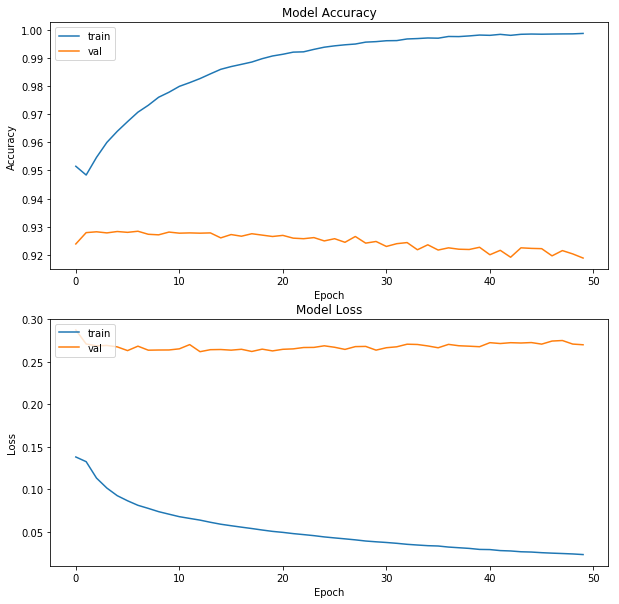

In [29]:
plt.figure(1, figsize=(10,10))  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(History.history['acc'])  
plt.plot(History.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(History.history['loss'])  
plt.plot(History.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

In [30]:
# Classification Report
y_true = np.argmax(test_targets, axis=1)
print(classification_report(y_true[:2000], predictions, target_names=labels))

C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

       Atelectasis       0.10      0.20      0.14       213
      Cardiomegaly       0.09      0.02      0.03       157
     Consolidation       0.00      0.00      0.00       104
             Edema       0.00      0.00      0.00        47
          Effusion       0.14      0.22      0.17       231
         Emphysema       0.00      0.00      0.00        65
          Fibrosis       0.06      0.01      0.02        76
            Hernia       0.00      0.00      0.00        23
      Infiltration       0.31      0.41      0.35       598
              Mass       0.02      0.01      0.02        69
            Nodule       0.08      0.16      0.10        90
Pleural_Thickening       0.00      0.00      0.00        99
         Pneumonia       0.00      0.00      0.00        24
      Pneumothorax       0.15      0.05      0.08       204

         micro avg       0.19      0.19      0.19      2000
         macro avg       0.07      0.0

### Train Predictions

In [31]:
predictions = [np.argmax(ChestRESN50_model.predict(np.expand_dims(feature, axis=0))) for feature in train_DENSNET]

ValueError: Found input variables with inconsistent numbers of samples: [2000, 7260]

In [35]:
y_true = np.argmax(train_targets, axis=1)
print(classification_report(y_true[:7260], predictions, target_names=labels))

                    precision    recall  f1-score   support

       Atelectasis       0.88      0.91      0.90      1161
      Cardiomegaly       0.98      0.92      0.95       296
     Consolidation       0.95      0.90      0.93       291
             Edema       1.00      0.92      0.96        91
          Effusion       0.89      0.92      0.90       911
         Emphysema       0.94      0.88      0.91       248
          Fibrosis       0.97      0.91      0.94       295
            Hernia       1.00      0.90      0.95        30
      Infiltration       0.90      0.94      0.92      1777
              Mass       0.95      0.87      0.91       503
            Nodule       0.88      0.90      0.89       788
Pleural_Thickening       0.94      0.92      0.93       318
         Pneumonia       0.99      0.93      0.96        71
      Pneumothorax       0.97      0.89      0.93       480

         micro avg       0.91      0.91      0.91      7260
         macro avg       0.94      0.9